#Logistic Reggression:
since CT_TOX is a categorical, I will use logistic regression

In [ ]:
import pandas as pd
import torch
from rdkit.DataStructs.cDataStructs import ExplicitBitVect

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report , precision_score, recall_score

In [ ]:
def fingerprint_to_array(fp):
    arr = np.zeros((morgan_bits,), dtype=int)  # Create a zero array of correct size
    if fp is not None:
        DataStructs.ConvertToNumpyArray(fp, arr)  # Fill array with fingerprint bits
    return arr

X = np.array([fingerprint_to_array(fp) for fp in valid_morgan_data['morgan']])
y = valid_morgan_data['CT_TOX'].values  # Toxicity labels

# Check shapes
print(f"Feature shape: {X.shape}, Label shape: {y.shape}")

Feature shape: (1487, 4096), Label shape: (1487,)


In [ ]:


# Split into train, validation, and test sets - stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123) # 70% train

Baseline model - logistic regression

In [ ]:
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=123
)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

In [ ]:
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))
print(confusion_matrix(y_test, y_pred_baseline))

Final Test Accuracy: 0.9105145413870246
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       413
           1       0.41      0.38      0.39        34

    accuracy                           0.91       447
   macro avg       0.68      0.67      0.67       447
weighted avg       0.91      0.91      0.91       447

[[394  19]
 [ 21  13]]


The logistic regression model performs well on non toxic molecules, but performs poorly on toxic molecules

#Ridge

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
ridge_model = LogisticRegressionCV(
    penalty='l2',# Use Ridge (L2 regularization)
    solver='lbfgs',# for L2
    cv=3,# 3-fold cross-validation
    scoring='accuracy',
    max_iter=1000,
    class_weight='balanced',
    random_state=123
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import confusion_matrix

print("Best C value:", ridge_model.C_)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))
print(confusion_matrix(y_test, y_pred_ridge))

Best C value: [0.35938137]
Final Test Accuracy: 0.9149888143176734
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       413
           1       0.42      0.29      0.34        34

    accuracy                           0.91       447
   macro avg       0.68      0.63      0.65       447
weighted avg       0.90      0.91      0.91       447

[[399  14]
 [ 24  10]]


The class weight was set to be balanced due to the low number of toxic molecules in the data set. When the model predicts that a molecule is non toxic, it has 94% accuracy. The model actually identifies 97% of all actual non-toxic molecules. However, it behaves poorly on toxic molecules, which is a bad sign. The Ridge model performs better than the baseline logistic regression model in terms of predicting toxic molecules with fewer false positives (higher precision). However, the recall dropped slightly for toxic molecules, indicating that the model became more conservative in calling something toxic.
Based on the confusion matrix, the True Negative and False Positive improved. However, since the True Positive (catching toxic drugs) went down, this is a bad sign. I will try adjusting the threshold.

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = ridge_model.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)


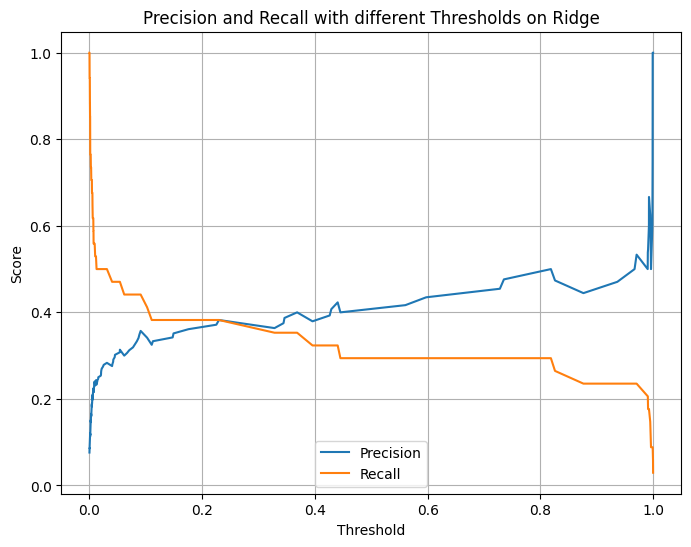

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall with different Thresholds on Ridge')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred_custom = (y_scores >= 0.3).astype(int) # classify as toxic


print("Custom threshold performance:")
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

Custom threshold performance:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       413
           1       0.36      0.35      0.36        34

    accuracy                           0.90       447
   macro avg       0.66      0.65      0.65       447
weighted avg       0.90      0.90      0.90       447

[[392  21]
 [ 22  12]]


In [ ]:
y_pred_custom = (y_scores >= 0.04).astype(int)

print("Custom threshold performance:")
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

Custom threshold performance:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       413
           1       0.28      0.47      0.35        34

    accuracy                           0.87       447
   macro avg       0.61      0.68      0.64       447
weighted avg       0.90      0.87      0.88       447

[[371  42]
 [ 18  16]]


After adjusting the threshold, the recall for toxicity went up, while the recall for non toxic drugs went down. There is a trade off between choosing precision and recall. When I chose y_scores >= 0.04, the recall for toxicity went significantly up, while the accuracy went down a little bit, so I will use this for the final assesment.

#PCA

In [ ]:
print(X.shape) # morgan FP of all molecules that we can obtain FP

(1487, 4096)


In [ ]:
fingerprint_df = pd.DataFrame(X)
fingerprint_cov_matrix = fingerprint_df.cov()
print(fingerprint_cov_matrix.iloc[:10, :10])

          0         1         2         3         4         5         6  \
0  0.004021 -0.000008 -0.000128 -0.000005 -0.000046 -0.000201 -0.000068   
1 -0.000008  0.002015 -0.000064 -0.000003 -0.000023 -0.000100 -0.000034   
2 -0.000128 -0.000064  0.030629 -0.000043 -0.000362  0.000445  0.000814   
3 -0.000005 -0.000003 -0.000043  0.001344 -0.000015 -0.000067 -0.000023   
4 -0.000046 -0.000023 -0.000362 -0.000015  0.011309 -0.000569 -0.000192   
5 -0.000201 -0.000100  0.000445 -0.000067 -0.000569  0.047320 -0.000164   
6 -0.000068 -0.000034  0.000814 -0.000023 -0.000192 -0.000164  0.016541   
7 -0.000073 -0.000037 -0.000574 -0.000024 -0.000208  0.001115  0.002386   
8 -0.000073 -0.000037  0.004809 -0.000024 -0.000208 -0.000904 -0.000305   
9 -0.000011 -0.000005 -0.000085 -0.000004 -0.000031 -0.000134 -0.000045   

          7         8         9  
0 -0.000073 -0.000073 -0.000011  
1 -0.000037 -0.000037 -0.000005  
2 -0.000574  0.004809 -0.000085  
3 -0.000024 -0.000024 -0.000004  
4 -0

In [ ]:
fingerprint_corr_matrix = fingerprint_df.corr()


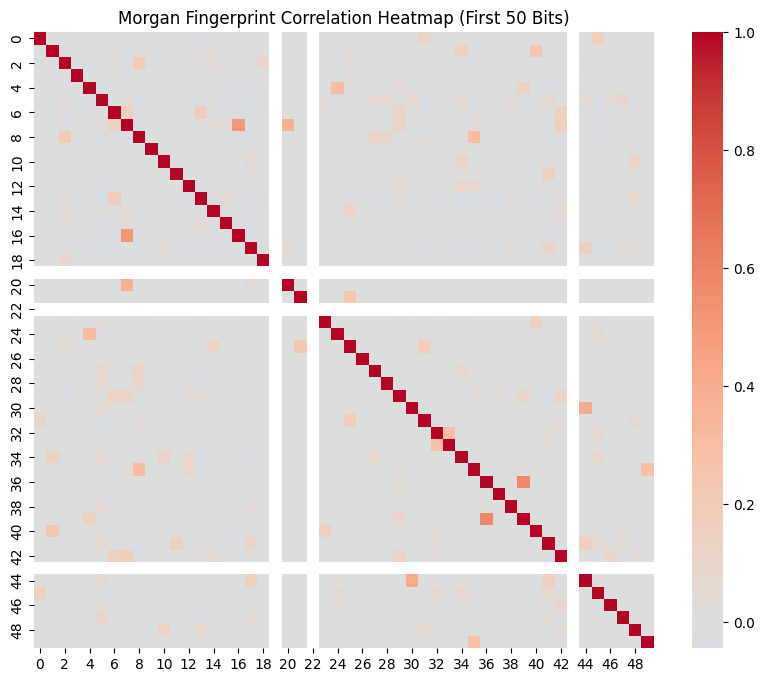

In [ ]:



plt.figure(figsize=(10, 8))
sns.heatmap(fingerprint_corr_matrix.iloc[:50, :50], cmap="coolwarm", center=0)  # Show only first 50 bits
plt.title("Morgan Fingerprint Correlation Heatmap (First 50 Bits)")
plt.show()

In [ ]:
permuted_df = fingerprint_df.sample(frac=1, random_state=123).reset_index(drop=True) # permute rows
permuted_df = permuted_df.sample(frac=1, axis=1, random_state=123) # permute columns

permuted_cov_matrix = permuted_df.corr()


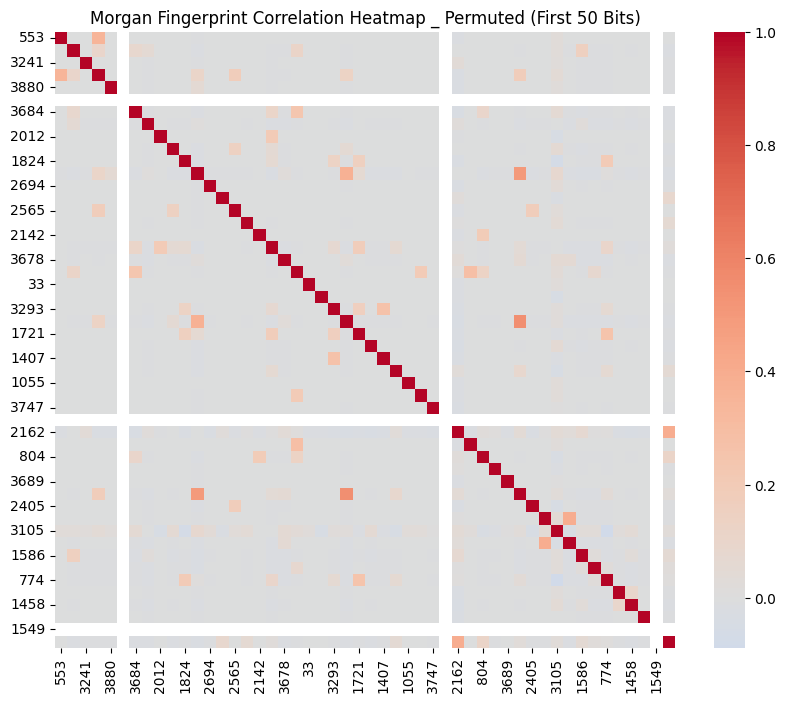

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(permuted_cov_matrix.iloc[:50, :50], cmap="coolwarm", center=0)  # Show only first 50 bits
plt.title("Morgan Fingerprint Correlation Heatmap _ Permuted (First 50 Bits)")
plt.show()

It seems like the feature matrix is uncorrelated in design. After plotting the initial correlation matrix, it seemed like the features were more uncorrelated than expected. So, I tried permuting the columns (Morgan Finger Prints) and rows (drugs). The result seemed similar, having low correlation between the chemical structures. Since I only mapped 50 of them, I tried using a quantitative metric of correlation

In [ ]:
# instead of only showing 50, use quantitative metric of correlation
np.fill_diagonal(fingerprint_corr_matrix.values, np.nan)

# Take mean of absolute values, ignoring NaNs
mean_abs_corr = np.nanmean(np.abs(fingerprint_corr_matrix.values))

print(f"Mean absolute inter-feature correlation: {mean_abs_corr:.4f}")

Mean absolute inter-feature correlation: 0.0121


on average, correlation between different fingerprint bits is 1.21% in absolute value

In [ ]:
# Stack correlation matrix into long-form (pairwise comparisons) - another approach - find top 10 most correlated feature pairs
corr_pairs = fingerprint_corr_matrix.where(np.triu(np.ones(fingerprint_corr_matrix.shape), k=1).astype(bool))
top_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False)

print("Top 10 most strongly correlated fingerprint bits:")
print(top_corr_pairs.head(10))


Top 10 most strongly correlated fingerprint bits:
2425  36      1.0
4094  2822    1.0
1685  566     1.0
2714  1817    1.0
3315  1201    1.0
3256  49      1.0
2841  1462    1.0
3165  312     1.0
3315  1111    1.0
3928  293     1.0
dtype: float64


In [ ]:
# Stack upper triangle of correlation matrix (excluding diagonal)
corr_pairs = fingerprint_corr_matrix.where(np.triu(np.ones(fingerprint_corr_matrix.shape), k=1).astype(bool))
top_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False)

# Count how many pairs have correlation > 0.9
high_corr_count = (top_corr_pairs > 0.9).sum()

print(f"Number of fingerprint bit pairs with correlation > 0.9: {high_corr_count}")

Number of fingerprint bit pairs with correlation > 0.9: 160


Out of 4096 features, 160 bit pairs have correlation that is higher than 0.9, so I decided to try using PCA.

In [ ]:
# extract feature indices with corr higher than 0.9
high_corr_pairs = top_corr_pairs[top_corr_pairs > 0.9]

high_corr_indices = set()
for i, j in high_corr_pairs.index:
    high_corr_indices.add(i)
    high_corr_indices.add(j)

high_corr_indices = sorted(high_corr_indices)
print(f"Number of unique fingerprint bits with correlation > 0.9: {len(high_corr_indices)}")  # 211 unique fingerprints with >0.9 correlation
print(f"Example indices: {high_corr_indices[:10]}")

Number of unique fingerprint bits with correlation > 0.9: 211
Example indices: [33, 36, 49, 61, 78, 83, 111, 125, 199, 216]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

Original shape: (1487, 4096)
Reduced shape: (1487, 915)


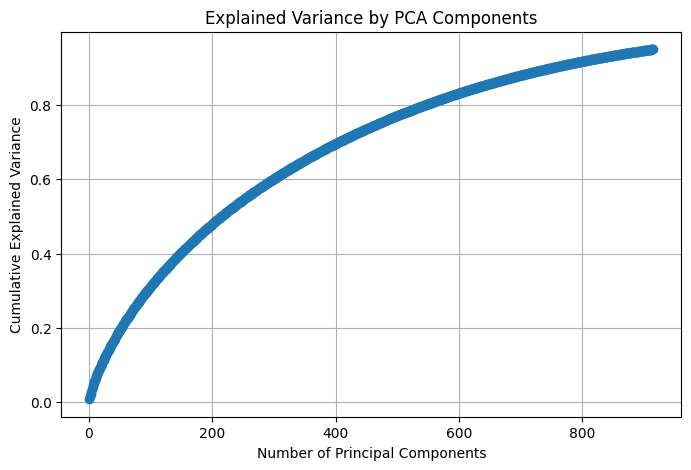

In [ ]:
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")
#print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

I wasn't expecting much from the PCA since there were only 160 out of 4096 features with correlation that was higher than 0.9. Based on the result above, doing PCA doesn't seem helpful, so I decided not to do it.

# Feature Engineering: Ridge

Based on the Ridge model, I will try to extract the coefficients that seem to be important factors and try multiplying the columns to generate new features.

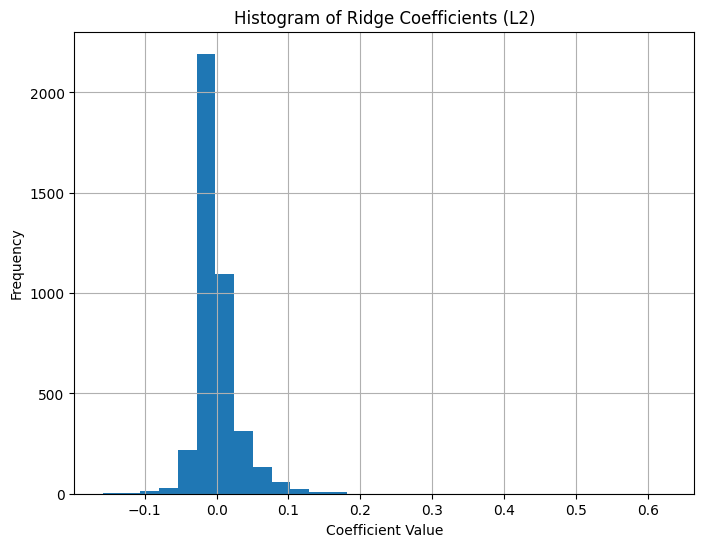

In [ ]:
coefs = ridge_model.coef_.flatten()
plt.figure(figsize=(8, 6))
plt.hist(coefs, bins=30)
plt.title("Histogram of Ridge Coefficients (L2)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
k = 10
coefs = ridge_model.coef_.flatten()
top_indices = np.argsort(np.abs(coefs))[::-1][:k]

print("Top-k indices:", top_indices)

Top-k indices: [3356    9 2700 2437 4029 3530  456 1538  620 2723]


In [ ]:
import itertools

def add_interactions(X, indices): # pairwise interaction features for train, test
    interactions = []
    for i, j in itertools.combinations(indices, 2):
        interaction = (X[:, i] * X[:, j]).reshape(-1, 1)
        interactions.append(interaction)
    return np.hstack(interactions)

X_train_inter = add_interactions(X_train, top_indices)
X_test_inter = add_interactions(X_test, top_indices)

X_train_aug = np.hstack([X_train, X_train_inter])
X_test_aug = np.hstack([X_test, X_test_inter])

scaler = StandardScaler()
X_train_aug_scaled = scaler.fit_transform(X_train_aug)
X_test_aug_scaled = scaler.transform(X_test_aug)

ridge_aug_model = LogisticRegressionCV(
    penalty='l2',
    solver='lbfgs',
    cv=3,
    scoring='accuracy',
    max_iter=1000,
    class_weight='balanced',
    random_state=123
)

ridge_aug_model.fit(X_train_aug_scaled, y_train)

n_original = X_train.shape[1]
inter_coefs = ridge_aug_model.coef_.flatten()[n_original:]

sorted_inter_idx = np.argsort(np.abs(inter_coefs))[::-1][:10]
print("\nTop interaction terms by coefficient magnitude:")
for rank, idx in enumerate(sorted_inter_idx):
    feat_i, feat_j = list(itertools.combinations(top_indices, 2))[idx]
    print(f"{rank+1}. Feature {feat_i} * Feature {feat_j} => Coef: {inter_coefs[idx]:.4f}")


Top interaction terms by coefficient magnitude:
1. Feature 2437 * Feature 456 => Coef: 0.1756
2. Feature 620 * Feature 2723 => Coef: -0.1661
3. Feature 2437 * Feature 1538 => Coef: 0.1064
4. Feature 2437 * Feature 4029 => Coef: 0.0521
5. Feature 2700 * Feature 456 => Coef: 0.0000
6. Feature 2700 * Feature 4029 => Coef: 0.0000
7. Feature 2700 * Feature 2437 => Coef: 0.0000
8. Feature 9 * Feature 2723 => Coef: 0.0000
9. Feature 9 * Feature 620 => Coef: 0.0000
10. Feature 9 * Feature 1538 => Coef: 0.0000


In [ ]:
inter_coefs.shape

(45,)

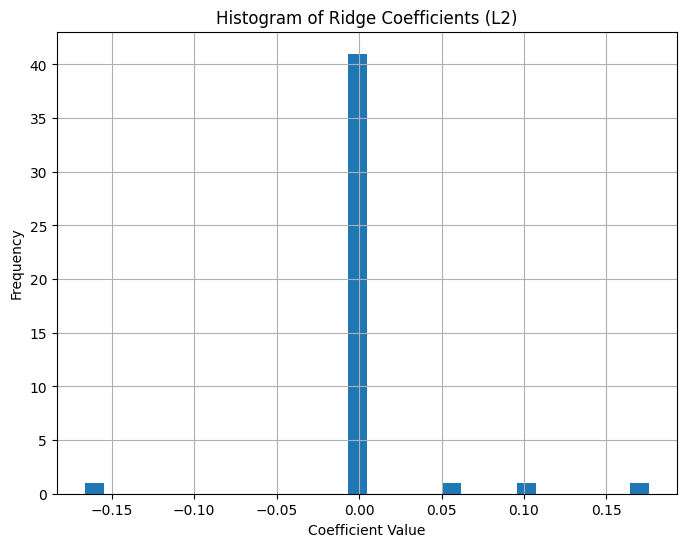

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(inter_coefs, bins=30)
plt.title("Histogram of Ridge Coefficients (L2)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
print("Original feature count:", X_train.shape[1])
print("Interaction feature count:", X_train_inter.shape[1])
print("Total features used in training:", X_train_aug.shape[1])

Original feature count: 4096
Interaction feature count: 45
Total features used in training: 4141


In [ ]:
y_aug_ridge= ridge_aug_model.predict(X_test_aug_scaled)

print("Final Test Accuracy:", accuracy_score(y_test, y_aug_ridge))
print(classification_report(y_test, y_aug_ridge))
print(confusion_matrix(y_test, y_aug_ridge))

Final Test Accuracy: 0.9172259507829977
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       413
           1       0.43      0.29      0.35        34

    accuracy                           0.92       447
   macro avg       0.69      0.63      0.65       447
weighted avg       0.90      0.92      0.91       447

[[400  13]
 [ 24  10]]


The result seems very similar with the original Ridge model. Adding these additional interactions did not improve the model's performance. The selected interactions may not have meaningful nonlinear relationship for predicting toxicity.